# Dynamic Simulation <a class="anchor" id="top"></a>

- **Prepared by:**
    
    - [Joy Zhang](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)
    
- **Covered topics:**

    - [1. Understanding dynamic simulation with QSDsan](#s1)
    - [2. Writing a dynamic SanUnit](#s2)
    - [3. Other convenient features](#s3)
    
- **Video demo:**

    - [Yalin Li](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)
    
To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FQSD-group%252FQSDsan%26urlpath%3Dtree%252FQSDsan%252Fdocs%252Fsource%252Ftutorials%26branch%3Dmain).
    
You can also watch a video demo on [YouTube](https://youtu.be/1Rr1QxUiE5k) (subscriptions & likes appreciated!).

---
From previous tutorials, we've covered how to use QSDsan's [SanUnit](https://qsdsan.readthedocs.io/en/latest/tutorials/5_SanUnit_advanced.html) and [WasteStream](https://qsdsan.readthedocs.io/en/latest/tutorials/3_WasteStream.html) classes to model the mass/energy flows throughout a system. You may have noticed, the simulation results generated by `SanUnit._run` are **static**, i.e., they don't carry time-related information. 

In this tutorial, we will learn about the **dynamic** simulation features in QSDsan. First we will focus on performing dynamic simulations with an existing system to understand the basics. Then we'll go over how to implement your own algorithms for dynamic simulations. 

In [1]:
import qsdsan as qs, exposan
print(f'This tutorial was made with qsdsan v{qs.__version__} and exposan v{exposan.__version__}')

This tutorial was made with qsdsan v1.3.1 and exposan v1.3.1


## 1. Understanding dynamic simulation with QSDsan <a class="anchor" id="s1"></a>

### 1.1. An example system
Let's use [Benchmark Simulation Model no.1 (BSM1)](http://iwa-mia.org/benchmarking/#BSM1) as an example. BSM1 describes an activated sludge treatment process that can be commonly found in conventional wastewater treatment facilities. The full system has been implemented in [EXPOsan](https://github.com/QSD-Group/EXPOsan/tree/main/exposan/bsm1).

The activated sludge process is often characterized as a series of biokinetic reactions in parallel (recap on `Process` [here](https://qsdsan.readthedocs.io/en/latest/tutorials/10_Process.html)). The mathematical models of this kind cannot output mass flows or concentrations directly as a function of input. But rather, they describe the rates of change in state variables at any time as a function of the state variables (often concentrations). As a result, simulation of such systems involves solving a series of ordinary differential equations (ODEs). We have developed features in QSDsan for this specific purpose.

#### 1.1.1. Running dynamic simulation

In [2]:
# Let's load the BSM1 system first
from exposan import bsm1
bsm1.load()
sys = bsm1.sys
sys.show()

System: bsm1_sys
ins...
[0] wastewater  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_I   23.1
                    S_S   53.4
                    X_I   39.4
                    X_S   155
                    X_BH  21.7
                    S_NH  1.34
                    S_ND  0.381
                    ...   4.26e+04
outs...
[0] effluent  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow: 0
[1] WAS  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow: 0


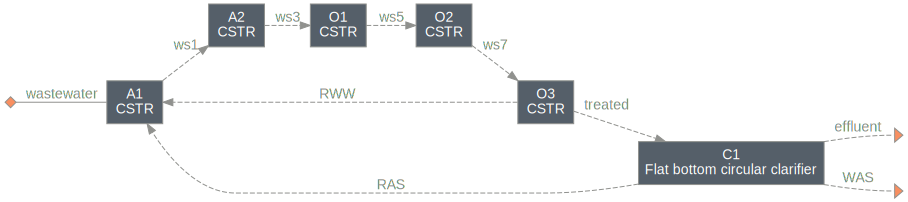

In [3]:
# The BSM1 system is composed of 5 CSTRs in series, 
# followed by a flat-bottom circular clarifier.
# sys.units
sys.diagram()

In [4]:
# If we try to simulate it like we'd do for a "static" system
# sys.simulate()

We run into this error because QSDsan (essentially biosteam in the background) considers this system dynamic, and additional arguments are required for `simulate` to work.

In [5]:
# We can verify that by
sys.isdynamic

True

In [6]:
# This is because the system contains at least one dynamic SanUnit
# {u: u.isdynamic for u in sys.units}

# If we disable dynamic simulation, then `simulate` would work as usual
sys.isdynamic = False
sys.simulate()

To perform a dynamic simulation of the system, we need to provide at least one additional keyword argument, i.e., `t_span`, as suggested in the error message. `t_span` is a 2-tuple indicating the simulation period.

>**Note**: Whether `t_span = (0,10)` means 0-10 days or 0-10 hours/minutes/months depends entirely on units of the parameters in the system's ODEs. For BSM1, it'd mean 0-10 days because all parameters in the ODEs express time in the unit of "day".

Other often-used keyword arguments include:

- `t_eval`: a 1d array to specify the output time points
- `method`: a string specifying the ODE solver
- `state_reset_hook`: specifies how to reset the simulation

`t_span`, `t_eval`, and `method` are essentially passed to [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function as keyword arguments. See [documentation](https://biosteam.readthedocs.io/en/latest/API/System.html#biosteam.System.dynamic_run) for a complete list of keyword arguments. You may notice that `scipy.integrate.solve_ivp` also requires input of `fun` (i.e., the ODEs) and `y0` (i.e., the initial condition). We'll learn later how `System.simulate` automates the compilation of these inputs.

---
### Tip
For systems that are expected to converge to some sort of "steady state", it is usually faster to simulate with implicit ODE solvers (e.g., `method = BDF` or `method = LSODA`) than with explicit ones. In case of one solver fails to complete integration through the entire specified simulation period, always try with alternative ones.

---

In [7]:
# Let's try simulating the BSM1 system from day 0 to day 50
# user shorter time or try changing method to 'RK23' (explicit solver) if it takes a long time
sys.isdynamic = True
sys.simulate(t_span=(0, 50), method='BDF', state_reset_hook='reset_cache')
sys.show()

System: bsm1_sys
Highest convergence error among components in recycle
streams {C1-1, O3-0} after 5 loops:
- flow rate   1.46e-11 kmol/hr (4.2e-14%)
- temperature 0.00e+00 K (0%)
ins...
[0] wastewater  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_I   23.1
                    S_S   53.4
                    X_I   39.4
                    X_S   155
                    X_BH  21.7
                    S_NH  1.34
                    S_ND  0.381
                    ...   4.26e+04
outs...
[0] effluent  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_I   22.6
                    S_S   0.67
                    X_I   3.3
                    X_S   0.142
                    X_BH  7.36
                    X_BA  0.43
                    X_P   1.3
                    ...   4.17e+04
[1] WAS  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_I   0.481
                    S_S   0.0143
                    X_I   36
                    X_S   1.55
          

#### 1.1.2. Retrieve dynamic simulation data
The `show` method only displays the system's state at the end of the simulation period. How do we retrieve information on system dynamics? QSDsan uses [Scope](https://qsdsan.readthedocs.io/en/latest/api/utils/scope.html) objects to keep track of values of state variables during simulation.

In [8]:
# This shows the units/streams whose state variables are kept track of 
# during dynamic simulations.
sys.scope.subjects

(<CSTR: A1>, <WasteStream: effluent>)

In [9]:
# We see that A1 and effluent are tracked, so we can retrieve their 
# time series data through their `scope` attribute, which stores a 
# `SanUnitScope` or `WasteStreamScope` object
A1 = sys.flowsheet.unit.A1
A1.scope
# eff = sys.flowsheet.stream.effluent
# eff.scope

<SanUnitScope: A1>

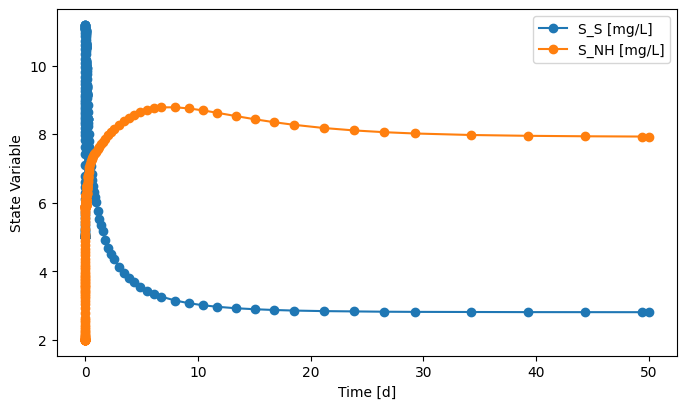

In [10]:
# `Scope` objects include a function for convenient visualization of time-series data
fig, ax = A1.scope.plot_time_series(('S_NH', 'S_S'))

In [11]:
# Raw time-series data are stored in
# A1.scope.record
A2 = sys.flowsheet.unit.A2
A2.scope
A2.scope.record

array([], shape=(0, 1), dtype=float64)

Each row in the `record` attribute is values of `A1`'s state variables at a certain time point.

In [12]:
# This stores the time data
A1.scope.time_series

array([0.000e+00, 5.096e-10, 1.019e-09, 6.115e-09, 1.121e-08, 6.217e-08,
       1.131e-07, 3.165e-07, 5.198e-07, 7.231e-07, 1.403e-06, 2.082e-06,
       2.762e-06, 8.671e-06, 1.458e-05, 2.049e-05, 3.168e-05, 4.286e-05,
       5.405e-05, 6.524e-05, 1.049e-04, 1.446e-04, 1.842e-04, 2.239e-04,
       3.090e-04, 3.941e-04, 4.793e-04, 5.644e-04, 6.495e-04, 8.358e-04,
       1.022e-03, 1.208e-03, 1.395e-03, 1.581e-03, 1.767e-03, 2.185e-03,
       2.602e-03, 2.895e-03, 3.189e-03, 3.398e-03, 3.567e-03, 3.736e-03,
       3.905e-03, 4.038e-03, 4.171e-03, 4.304e-03, 4.438e-03, 4.571e-03,
       4.704e-03, 4.849e-03, 4.993e-03, 5.138e-03, 5.283e-03, 5.427e-03,
       5.572e-03, 5.832e-03, 6.093e-03, 6.353e-03, 6.613e-03, 6.874e-03,
       7.332e-03, 7.790e-03, 8.248e-03, 8.706e-03, 9.407e-03, 1.011e-02,
       1.081e-02, 1.151e-02, 1.273e-02, 1.396e-02, 1.519e-02, 1.641e-02,
       1.848e-02, 2.055e-02, 2.195e-02, 2.335e-02, 2.476e-02, 2.616e-02,
       2.857e-02, 3.097e-02, 3.218e-02, 3.338e-02, 

The tracked time-series data can be exported to a file in two ways.

In [13]:
# sys.scope.export('bsm1_time_series.xlsx')

# or

# import numpy as np
# sys.simulate(state_reset_hook='reset_cache',
#              t_span=(0, 50),
#              t_eval=np.arange(0, 51, 1),
#              method='BDF',
#              export_state_to=('bsm1_time_series.xlsx'))

We can also (re-)define which unit or stream to track during dynamic simulation.

In [14]:
# Let's say we want to track the clarifier and the waste activated sludge
C1 = sys.flowsheet.unit.C1
WAS = sys.flowsheet.stream.WAS
sys.set_dynamic_tracker(C1, WAS)
sys.scope.subjects

(<FlatBottomCircularClarifier: C1>, <WasteStream: WAS>)

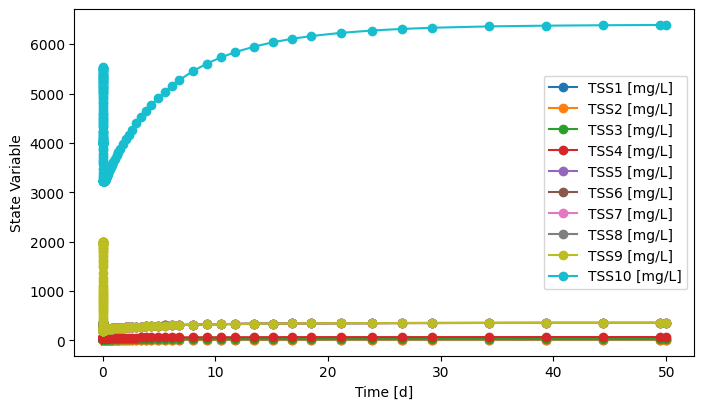

In [15]:
# Need to rerun the simulation before retrieving results
# user shorter time or try changing method to 'RK23' (explicit solver) if it takes a long time
sys.simulate(t_span=(0, 50), method='BDF', state_reset_hook='reset_cache')
fig, ax = C1.scope.plot_time_series([f'TSS{i}' for i in range(1,11)])

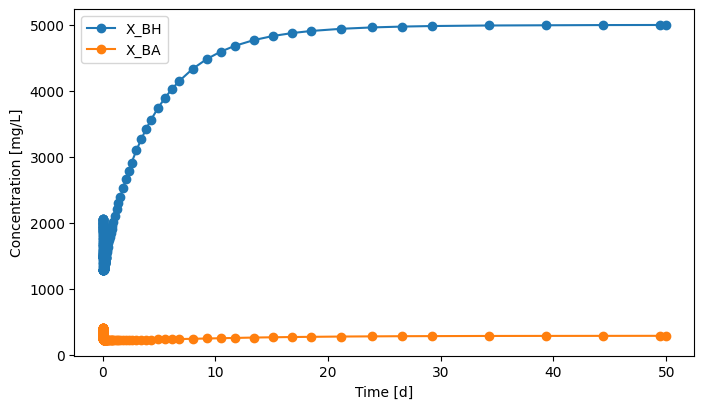

In [16]:
fig, ax = WAS.scope.plot_time_series(('X_BH', 'X_BA'))

So far we've learned how to simulate any dynamic system developed with QSDsan. 
A complete list of existing unit operations within QSDsan is available [here](https://qsdsan.readthedocs.io/en/latest/api/sanunits/_index.html). The column "Dynamic" indicates whether the unit is enabled for dynamic simulations. Any system composed of the enabled units can be simulated dynamically as we learned above.

[Back to top](#top)

### 1.2. When is a system "dynamic"?
It's ultimately the user's decision whether a system should be run dynamically. This section will cover the essentials to switch to the dynamic mode for system simulation.

#### `System.isdynamic` vs. `SanUnit.isdynamic` vs. `SanUnit.hasode` 

- Simply speaking, when the `<System>.isdynamic == True`, the program will attempt dynamic simulation. Users can directly enable/disable the dynamic mode by setting the `isdynamic` property of a `System` object.

- The program will set the value of `<System>.isdynamic` when it's not specified by users. `<System>.isdynamic` is considered `True` in all cases except when `<SanUnit>.isdynamic == False` for all units.

- Setting `<SanUnit>.isdynamic = True` does not gaurantee the unit can be simulated dynamically. Just like how the `_run` method must be defined for static simulation, a series of additional methods must be defined to enable dynamic simulation.

- `<SanUnit>.hasode == True` means a unit has the fundamental methods to compile ODEs. It is a **sufficient but not necessary** condition for dynamic simulation, because a unit doesn't have to be described with ODEs to be capable of dynamic simulations.

In [17]:
# All units in the BSM1 system above have ODEs
{u: u.hasode for u in sys.units}

{<CSTR: A1>: True,
 <CSTR: A2>: True,
 <CSTR: O1>: True,
 <CSTR: O2>: True,
 <CSTR: O3>: True,
 <FlatBottomCircularClarifier: C1>: True}

[Back to top](#top)

## 2. Writing a dynamic `SanUnit` <a class="anchor" id="s2"></a>

Whether a system can be simulated dynamically ultimately boils down to whether all the units in the system have the fundamental methods required for dynamic simulations. In this section, you'll learn how to implement your own algorithms to create a `SanUnit` subclass capable of dynamic simulations.

### 2.1. Basic structure <a class="anchor" id="s2.1"></a>

During typical system simulations, `_run` directly defines the static mass and/or energy flows of the effluent `WasteStream` objects of the unit after calculation. 

In comparison, during dynamic simulations, all information are stored as `_state` and `_dstate` attributes of the relevant `SanUnit` obejcts as well as `state` and `dstate` properties of `WasteStream` objects. These information won't be translated to mass or energy flows until dynamic simulation is completed.

- `WasteStream.state` is a 1d `numpy.array` of length $n+1$, $n$ is the length of the components associated with the `thermo`. Each element of the array represents value of one state variable.

---
#### Tip

Typically for a liquid `WasteStream`, the first $n$ element represents the component concentrations \[mg/L\], while the last element represents the total volumetric flow \[m3/d\]. For a gaseous `WasteStream`, the first $n$ state variables can simply be the mass flows \[g/d\] of the components if the last element is fixed at 1. This is because after completing dynamic simulations, the `WasteStream`'s mass flow is defined as the first $n$ element of this array multiplied by the last element.

---

- `WasteStrem.dstate` is an array of the exact same shape as `WasteStream.state`, storing values of the time derivatives (i.e., the rates of change) of the state variables.

In [18]:
sf = sys.flowsheet.stream
sf.effluent.state

array([3.000e+01, 8.899e-01, 4.389e+00, 1.886e-01, 9.784e+00, 5.720e-01,
       1.722e+00, 4.897e-01, 1.038e+01, 1.747e+00, 6.884e-01, 1.349e-02,
       4.954e+01, 2.751e+01, 9.978e+05, 1.806e+04])

In [19]:
# sf.effluent.F_vol*24  # convert unit from m3/hr to m3/d
sf.effluent.conc

sparse([3.000e+01, 8.899e-01, 4.389e+00, 1.886e-01, 9.784e+00, 5.720e-01,
        1.722e+00, 4.897e-01, 1.038e+01, 1.747e+00, 6.884e-01, 1.349e-02,
        4.954e+01, 2.751e+01, 9.981e+05])

In [20]:
sf.effluent.dstate.shape == sf.effluent.state.shape

True


- `SanUnit._state` is also a 1d `numpy.array`, but the length of the array is not assumed, because the state variables relevant for a `SanUnit` is entirely dependent on the unit operation itself. Therefore, there is no predefined units of measure or order for state variables of a unit operation.

- `SanUnit._dstate`, similarly, must have the exact same shape as the `_state` array, as each element corresponds to the time derivative of a state variable.

In [21]:
C1._state.shape == A1._state.shape
# C1._state.shape == C1._dstate.shape

False

In [22]:
# Some dynamic units in QSDsan have a `state` property that formats
# the data in `_state` for better readability
A1.state

{'S_I': 30.0,
 'S_S': 2.8098296544615704,
 'X_I': 1147.8970757884535,
 'X_S': 82.14996504835973,
 'X_BH': 2551.1712941951987,
 'X_BA': 148.18576250649838,
 'X_P': 447.1086242830684,
 'S_O': 0.004288622012845044,
 'S_NO': 5.33892893863284,
 'S_NH': 7.928812844268634,
 'S_ND': 1.216680910568711,
 'X_ND': 5.285760801254182,
 'S_ALK': 59.158219028756534,
 'S_N2': 25.008073542375985,
 'H2O': 997794.331078558,
 'Q': 92229.99999999996}

[Back to top](#top)

### 2.2. Fundamental methods
In addition to proper `__init__` and `_run` methods ([recap](https://qsdsan.readthedocs.io/en/latest/tutorials/5_SanUnit_advanced.html#2.1.-Fundamental-methods)), a few more methods are required in a `SanUnit` subclass for dynamic simulation. Users typically won't interact with these methods but they will be called by `System.simulate` to manipulate the values of the arrays mentioned [above](#s2.1) (i.e., `<SanUnit>._state`, `<SanUnit>._dstate`, `<WasteStream>.state`, and `<WasteStream>.dstate`).

- `_init_state`, called after `_run` to generate an initial condition for the unit, i.e., defining shape and values of the `_state` and `_dstate` arrays. For example:
```python
import numpy as np
def _init_state(self):
    inf = self.ins[0]
    self._state = np.ones(len(inf.components)+1)
    self._dstate = self._state * 0.
```
This method (not saying it makes sense) assumes $n+1$ state variables and gives an initial value of 1 to all of them. Then it also sets the initial time derivatives to be 0. 

- `_update_state`, to update effluent streams' state arrays based on current state (and maybe dstate) of the SanUnit. For example:
```python
def _update_state(self):
    arr = self._state   # retrieving the current state of the SanUnit
    eff, = self.outs    # assuming this SanUnit has one outlet only
    eff.state[:] = arr  # assume arr has the same shape as WasteStream.state
```
The goal of this method is to update the values in `<WasteStream>.state` for each `WasteStream` in `<SanUnit>.outs`.

- `_update_dstate`, to update effluent streams' `dstate` arrays based on current `_state` and `_dstate` of the SanUnit. The signiture and often the algorithm are similar to `_update_state`.


- `_compile_ODE` or `_compile_AE`, used to define the function that updates the `_dstate` and/or `_state` of the `SanUnit` based on its influent streams' `state`/`dstate` and potentially its own current state. The defined function will be stored as `SanUnit._ODE` or `SanUnit._AE`. These methods should follow some general forms like below:
```python
@property
def ODE(self):
    if self._ODE is None:
        self._compile_ODE()
    return self._ODE 
```

```python
def _compile_ODE(self):
    _dstate = self._dstate
    _update_dstate = self._update_dstate
    def dy_dt(t, y_ins, y, dy_ins):
        _dstate[:] = some_algorithm(t, y_ins, y, dy_ins)
        _update_dstate()
    self._ODE = dy_dt
```

```python
@property
def AE(self):
    if self._AE is None:
        self._compile_AE()
    return self._AE
```

```python
def _compile_AE(self):
    _state = self._state
    _dstate = self._dstate
    _update_state = self._update_state
    _update_dstate = self._update_dstate
    def y_t(t, y_ins, dy_ins):
        _state[:] = some_algorithm(t, y_ins, dy_ins)
        _dstate[:] = some_other_algorithm(t, y_ins, dy_ins)
        _update_state()
        _update_dstate()
    self._AE = y_t
```

> **Note**: Within the `dy_dt` or `y_t` functions, `<SanUnit>._state[:] = <new_value>` rather than `<SanUnit>._state = <new_value>` because it's generally faster to update values in an existing array than overwriting this array with a newly created array.

We'll learn more about these two methods in the next subsections.

[Back to top](#top)

### 2.3. Making a simple MixerSplitter (`_compile_AE`)

Let's say we want to make an ideal mixer-splitter that instantly mixes all streams at the inlets and then evenly split them across the outlets.

In [23]:
# Typically if implemented as a static SanUnit, it'd be pretty simple
# Let's ignore `_design` and `_cost` for now.
class MixerSplitter1(qs.SanUnit):
    _N_outs = 3
    _ins_size_is_fixed = False
    _outs_size_is_fixed = False
    def __init__(self, ID='', ins=None, outs=(), thermo=None, 
                 init_with='WasteStream', **kwargs):
        qs.SanUnit.__init__(self, ID, ins, outs, thermo, init_with, **kwargs)
        self.mixed = qs.WasteStream()
    
    def _run(self):
        mixed = self.mixed
        mixed.mix_from(self.ins)
        n_outs = len(self.outs)
        flow = mixed.get_total_flow('kg/hr')/n_outs
        for out in self.outs:
            out.copy_like(mixed)
            out.set_total_flow(flow, 'kg/hr')
            
    def _design(self):
        pass
    
    def _cost(self):
        pass

In [24]:
# Let's try simulating it with the components used in BSM1
cmps = qs.get_thermo().chemicals
cmps.show()

CompiledComponents([S_I, S_S, X_I, X_S, X_BH, X_BA, X_P, S_O, S_NO, S_NH, S_ND, X_ND, S_ALK, S_N2, H2O])


In [25]:
# Now let's make a couple fake influents
inf1 = qs.WasteStream(H2O=1000, S_O=5)
inf2 = qs.WasteStream(H2O=800, S_S=3, S_NH=2.1)
inf2.show()

WasteStream: ws12
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): S_S   3e+03
             S_NH  2.1e+03
             H2O   8e+05
 WasteStream-specific properties:
  pH         : 7.0
  Alkalinity : 2.5 mg/L
  COD        : 3711.8 mg/L
  BOD        : 2661.3 mg/L
  TC         : 1187.8 mg/L
  TOC        : 1187.8 mg/L
  TN         : 2598.2 mg/L
  TP         : 37.1 mg/L
 Component concentrations (mg/L):
  S_S    3711.8
  S_NH   2598.2
  H2O    989803.5


In [26]:
MS1 = MixerSplitter1(ins=(inf1, inf2))
MS1.simulate()
MS1.show()

MixerSplitter1: M1
ins...
[0] ws11
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): S_O  5e+03
                H2O  1e+06
    WasteStream-specific properties:
     pH         : 7.0
[1] ws12
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): S_S   3e+03
                S_NH  2.1e+03
                H2O   8e+05
    WasteStream-specific properties:
     pH         : 7.0
     COD        : 3711.8 mg/L
     BOD        : 2661.3 mg/L
     TC         : 1187.8 mg/L
     TOC        : 1187.8 mg/L
     TN         : 2598.2 mg/L
     TP         : 37.1 mg/L
outs...
[0] ws13
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (g/hr): S_S   1e+03
                S_O   1.67e+03
                S_NH  700
                H2O   6e+05
    WasteStream-specific properties:
     pH         : 7.0
     COD        : 1650.8 mg/L
     BOD        : 1183.6 mg/L
     TC         : 528.3 mg/L
     TOC        : 528.3 mg/L
     TN         : 1155.6 mg/L
     TP         : 16.5 mg/L
[1] ws14
phase: 'l', T: 298.15 K, P: 101325 Pa
flo

In [27]:
# Obviously, it's not ready for dynamic simulation
# MS1_dyn = MixerSplitter1(ins=(inf1.copy(), inf2.copy()), isdynamic=True)
# dyn_sys = qs.System(path=(MS1_dyn,))
# dyn_sys.simulate(t_span=(0,5))

Since the mixer-splitter mixes and splits instantly, we can express this process with a set of algebraic equations (AEs). Assume its array of state variables follow the "concentration-volumetric flow" convention. In mathematical forms, state variables of the mixer-splitter ($C_m$, component concentrations; $Q_m$, total volumetric flow) follow:
$$Q_m = \sum_{i \in ins} Q_i \tag{1}$$
$$Q_mC_m = \sum_{i \in ins} Q_iC_i$$
$$\therefore C_m = \frac{\sum_{i \in ins} Q_iC_i}{Q_m} \tag{2}$$

Therefore, the time derivatives $\dot{Q_m}$ follow:
$$\dot{Q_m} = \sum_{i \in ins} \dot{Q_i} \tag{3}$$
$$Q_m\dot{C_m} + C_m\dot{Q_m} = \sum_{i \in ins} (Q_i\dot{C_i} + C_i\dot{Q_i})$$
$$\therefore \dot{C_m} = \frac{1}{Q_m}\cdot(\sum_{i \in ins}Q_i\dot{C_i} + \sum_{i \in ins}C_i\dot{Q_i} - C_m\dot{Q_m}) \tag{4}$$

For any effluent `WasteStream` $j$:
$$Q_j = \frac{Q_m}{n_{outs}} \tag{5}$$
$$C_j = C_m \tag{6}$$
$$\therefore \dot{Q_j} = \frac{\dot{Q_m}}{n_{outs}} \tag{7}$$
$$\dot{C_j} = \dot{C_m} \tag{8}$$
Now, let's try to implement this algorithm in methods for dynamic simulation.

In [28]:
import numpy as np
class MixerSplitter2(MixerSplitter1):
    def _init_state(self):
        mixed = self.mixed
        self._state = np.empty(len(cmps)+1)
        self._state[:-1] = mixed.conc  # first n element be the component concentrations of the mixed stream
        self._state[-1] = mixed.F_vol * 24 # last element be the total volumetric flow
        self._dstate = self._state * 0.
    
    def _update_state(self):
        y = self._state
        n_outs = len(self.outs)
        for ws in self.outs:
            if ws.state is None: ws.state = y.copy()
            else: ws.state[:-1] = y[:-1] # equation (6)
            ws.state[-1] = y[-1]/n_outs  # equation (5)
    
    def _update_dstate(self):
        dy = self._dstate
        n_outs = len(self.outs)
        for ws in self.outs:
            if ws.dstate is None: ws.dstate = dy.copy()
            else: ws.dstate[:-1] = dy[:-1]  # equation (8)
            ws.dstate[-1] = dy[-1]/n_outs   # equation (7)
    
    @property
    def AE(self):
        if self._AE is None:
            self._compile_AE()
        return self._AE
    
    def _compile_AE(self):
        _state = self._state
        _dstate = self._dstate
        _update_state = self._update_state
        _update_dstate = self._update_dstate
        def y_t(t, y_ins, dy_ins):
            Q_ins = y_ins[:,-1]
            C_ins = y_ins[:,:-1]
            dQ_ins = dy_ins[:,-1]
            dC_ins = dy_ins[:,:-1]
            _state[-1] = Q = sum(Q_ins)           # equation (1)
            _state[:-1] = C = Q_ins @ C_ins / Q   # equation (2)
            _dstate[-1] = dQ = sum(dQ_ins)        # equation (3)
            _dstate[:-1] = dC = (Q_ins @ dC_ins + dQ_ins @ C_ins - C*dQ) / Q  # equation (4)
            _update_state()
            _update_dstate()
        self._AE = y_t

>**Note**: 
>1. All `SanUnit._AE` must take exactly these three postional arguments (`t`, `y_ins`, `dy_ins`). `t` is time as a `float`. Both `y_ins` and `dy_ins` are **2d** `numpy.array` of the same shape `(m, n+1)`, where $m$ is the number of inlets, $n+1$ is the length of the `state` or `dstate` array of a `WasteStream`.
>
>2. All `SanUnit._AE` must update both `_state` and `_dstate` of the `SanUnit`, and must call `_update_state` and `_update_dstate` afterwards.

In [29]:
# Now let's see if this works
MS2 = MixerSplitter2(ins=(inf1.copy(), inf2.copy()), isdynamic=True)
dyn_sys2 = qs.System(path=(MS2,))
dyn_sys2.set_dynamic_tracker(MS2)
dyn_sys2.simulate(t_span=(0,5))

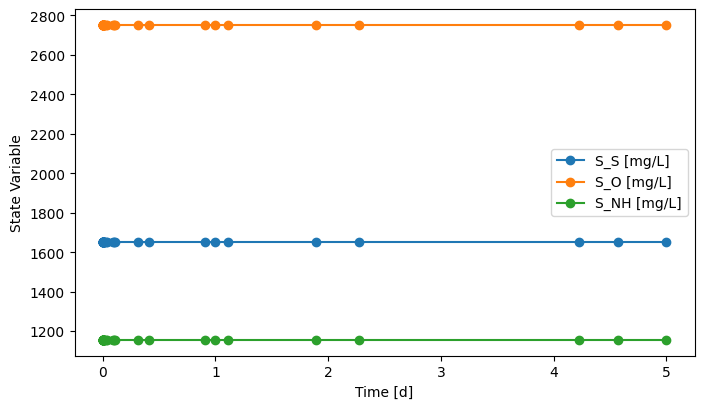

In [30]:
# You'll see the mass flows stay constant through the simulation period, 
# but still it means the system was simulated dynamically.
fig, ax = MS2.scope.plot_time_series(('S_S', 'S_NH', 'S_O'))

Many commonly used unit operations, such as [Pump](https://qsdsan.readthedocs.io/en/latest/api/sanunits/pumping.html#qsdsan.sanunits.Pump), [Mixer](https://qsdsan.readthedocs.io/en/latest/api/sanunits/abstract.html#mixer), [Splitter](https://qsdsan.readthedocs.io/en/latest/api/sanunits/abstract.html#splitter), and [HydraulicDelay](https://qsdsan.readthedocs.io/en/latest/api/sanunits/pumping.html#hydraulicdelay), have implemented the fundamental methods to be used in a dynamic system. You can always refer to the source codes of these units to learn more about how they work.

[Back to top](#top)

### 2.4. Making an inactive CompleteMixTank (`_compile_ODE`)

As you can see above, it's not very impressive to dynamically simulate a system without any ODEs. So let's make a simple inactive complete mix tank. Assume the reactor has a fixed liquid volume $V$, and thus the effluent volumetric flow rate changes instantly with influents. The mass balance of this type of reactor can be described as:
$$Q = \sum_{i \in ins} Q_i \tag{9}$$
$$\therefore \dot{Q} = \sum_{i \in ins} \dot{Q_i} \tag{10}$$
$$\frac{d(VC)}{dt} = \sum_{i \in ins} Q_iC_i - QC$$
$$\therefore \dot{C} = \frac{1}{V}(\sum_{i \in ins} Q_iC_i - QC) \tag{11}$$
Equations (10) and (11) are the governing ODEs of this unit.

In [31]:
class CompleteMixTank(qs.SanUnit):
    
    _N_outs = 1
    _ins_size_is_fixed = False
    
    def __init__(self, ID='', ins=None, outs=(), thermo=None, 
                 init_with='WasteStream', V=10, **kwargs):
        qs.SanUnit.__init__(self, ID, ins, outs, thermo, init_with, **kwargs)
        self.V = V
        
    def _run(self):
        out, = self.outs
        out.mix_from(self.ins)
    
    def set_init_conc(self,**concentrations):
        cmps = self.thermo.chemicals
        C = np.zeros(len(cmps))
        idx = cmps.indices(list(concentrations.keys()))
        C[idx] = list(concentrations.values())
        self._init_concs = C
    
    def _init_state(self):
        out, = self.outs
        self._state = np.empty(len(cmps)+1)
        self._state[:-1] = self._init_concs      # first n element be the component concentrations of the mixed stream
        self._state[-1] = out.F_vol*24   # last element be the total volumetric flow
        self._dstate = self._state*0.
        
    def _update_state(self):
        out, = self.outs
        out.state = self._state
        
    def _update_dstate(self):
        out, = self.outs
        out.dstate = self._dstate
        
    @property
    def ODE(self):
        if self._ODE is None:
            self._compile_ODE()
        return self._ODE 
    
    def _compile_ODE(self):
        _dstate = self._dstate
        _update_dstate = self._update_dstate
        V = self.V
        def dy_dt(t, y_ins, y, dy_ins):
            Q_ins = y_ins[:,-1]
            C_ins = y_ins[:,:-1]
            dQ_ins = dy_ins[:,-1]
            Q = sum(Q_ins)   # equation (9)
            C = y[:-1]
            _dstate[-1] = sum(dQ_ins) # dQ, equation (10)
            _dstate[:-1] = (Q_ins @ C_ins - Q*C)/V # dC, equation (11)
            _update_dstate()
        self._ODE = dy_dt

>**Note**: 
>1. All `SanUnit._ODE` must take exactly these four postional arguments: `t`, `y_ins`, and `dy_ins` are the same as the ones in `SanUnit._AE`. `y` is a **1d** `numpy.array`, because it is equal to the `_state` array of the unit.
>
>2. Unlike `_AE`, all `SanUnit._ODE` updates only the `_dstate` array of the `SanUnit`, and only calls `_update_dstate` afterwards.

In [32]:
# Let's see if it works
CMT = CompleteMixTank(ins=(inf1.copy(), inf2.copy()), V=50,
                      isdynamic=True)
dyn_sys3 = qs.System(path=(CMT,))
dyn_sys3.set_dynamic_tracker(CMT)

# To make it more interesting, we'll set the initial condition to be 
# something not the steady state.
CMT.set_init_conc(S_S=500, S_NH=700, S_O=290)
dyn_sys3.simulate(t_span=(0,5))

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='State Variable'>)

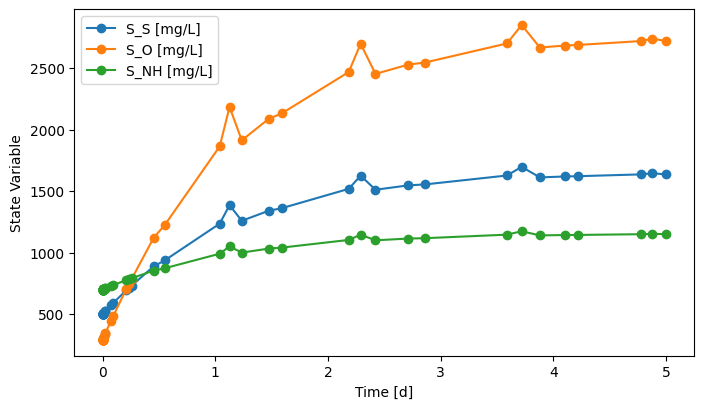

In [33]:
CMT.scope.plot_time_series(('S_NH', 'S_S', 'S_O'))

Many commonly used unit operations described by ODEs have been implemented in QSDsan, such as [CSTR](https://qsdsan.readthedocs.io/en/latest/api/sanunits/suspended_growth_bioreactors.html#cstr), [BatchExperiment](https://qsdsan.readthedocs.io/en/latest/api/sanunits/suspended_growth_bioreactors.html#batchexperiment), and [FlatBottomCircularClarifier](https://qsdsan.readthedocs.io/en/latest/api/sanunits/clarifiers.html).

[Back to top](#top)

## 3. Other convenient features <a class="anchor" id="s3"></a>
### 3.1. `ExogenousDynamicVariable`
The [ExogenousDynamicVariable](https://qsdsan.readthedocs.io/en/latest/api/utils/dynamics.html#exogenousdynamicvariable) class is created to enable incorporation of exogenous dynamic variables in unit simulations. By "dynamic", it means the variable value changes over time. By "exogenous", it means the variable isn't explicitly dependent on any unit operation or stream. "Ambient temperature" or "sunlight irradiance" is a good example. They are environmental conditions that are often beyond control but have an effect on the operation or performance of the system.

In [34]:
# Check out the documentation
from qsdsan.utils import ExogenousDynamicVariable as EDV
# EDV?

There are generally two ways to create an `ExogenousDynamicVariable`.

1. __Define the variable as a function of time.__ Let's say we want to create a variable to represent the changing reaction temperature. Assume the temperature value \[K\] can be expressed as $T = 298.15 + 5\cdot \sin(t)$, indicating that the temperatue fluctuacts around $25^{\circ}C$ by $\pm 5^{\circ}C$. Then simply,
```python
T = EDV('T', function=lambda t: 298.15+5*np.sin(t))
```

2. __Provide time-series data to describe the dynamics of the variable.__ For demonstration purpose, we'll just make up the data. In practice, this is convenient if you have real data.
```python
t_arr = np.linspace(0, 5)
y_arr = 298.15+5*np.sin(t_arr)
T = EDV('T', t=t_arr, y=y_arr)
```

For convenience, `ExogenousDynamicVariable` also has a `classmethod` that enables batch creation of multiple variables at once. We just need to provide a file of the time-series data, including a column `t` for time points and additional columns of the variable values. See the [documentation](https://qsdsan.readthedocs.io/en/latest/api/utils/dynamics.html#qsdsan.utils.ExogenousDynamicVariable.batch_init) of `ExogenousDynamicVariable.batch_init` for detailed usage.

In [35]:
# EDV.batch_init?

Once created, these `ExogenousDynamicVariable` objects can be incorporated into any `SanUnit` upon its initialization or through the `SanUnit.exo_dynamic_vars` property setter. 

In [36]:
# Let's see an example
from exposan.metab import create_system
sys_mt = create_system()
uf_mt = sys_mt.flowsheet.unit
uf_mt.R1.exo_dynamic_vars

All impact indicators have been removed from the registry.
All impact items have been removed from the registry.


(<ExogenousDynamicVariable: T>,)

In [37]:
# The evaluation of these variables during unit simulation is done through 
# the `eval_exo_dynamic_vars` method
uf_mt.R1.eval_exo_dynamic_vars(t=0.1)

[295.15]

[Back to top](#top)

### 3.2. `DynamicInfluent`
The [DynamicInfluent](https://qsdsan.readthedocs.io/en/latest/api/sanunits/DynamicInfluent.html) is a `SanUnit` subclass for generating dynamic influent streams from user-defined time-series data. The use of this class is, to some extent, similar to an `ExogenousDynamicVariable`.

In [38]:
from qsdsan.sanunits import DynamicInfluent as DI
# DI?

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='State Variable'>)

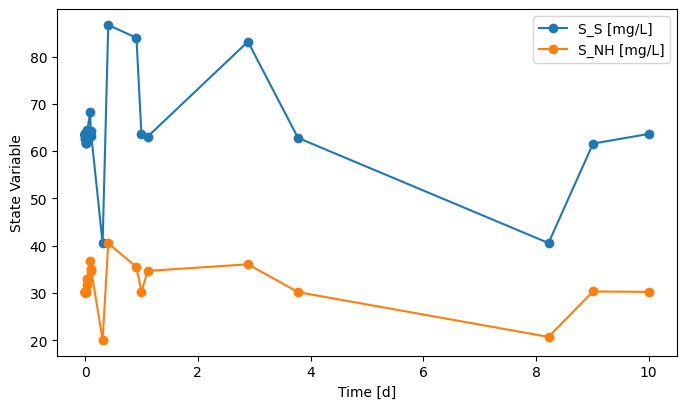

In [39]:
qs.set_thermo(bsm1.cmps)
DI1 = DI(outs=('dynamic_stream',))
sys_di = qs.System(path=(DI1,))
sys_di.set_dynamic_tracker(DI1)
sys_di.simulate(t_span=(0, 10))
DI1.scope.plot_time_series(('S_NH', 'S_S'))

[Back to top](#top)